In [2]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks2/MSFT.csv")

In [6]:
df = df[['Date', 'Close']]

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9224,2022-10-17,237.529999
9225,2022-10-18,238.500000
9226,2022-10-19,236.479996
9227,2022-10-20,236.149994


In [9]:
import datetime

df['Date'] = pd.to_datetime(df['Date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9229 entries, 0 to 9228
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9229 non-null   datetime64[ns]
 1   Close   9229 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 144.3 KB


In [10]:
df.index = df.pop('Date')

df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-10-17,237.529999
2022-10-18,238.500000
2022-10-19,236.479996


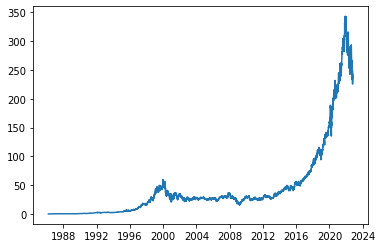

In [13]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])

In [26]:
import numpy as np
import datetime

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = datetime.datetime.strptime(first_date_str, '%Y-%m-%d')
  last_date  = datetime.datetime.strptime(last_date_str, '%Y-%m-%d')

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-10-21', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
394,2022-10-17,225.750000,234.240005,228.559998,237.529999
395,2022-10-18,234.240005,228.559998,237.529999,238.500000
396,2022-10-19,228.559998,237.529999,238.500000,236.479996
397,2022-10-20,237.529999,238.500000,236.479996,236.149994


In [27]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((399,), (399, 3, 1), (399,))

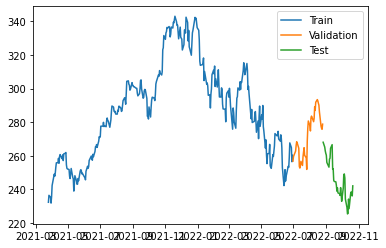

In [28]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
10/10 [==============================] - 3s 66ms/step - loss: 82935.1406 - mean_absolute_error: 286.6243 - val_loss: 73481.9766 - val_mean_absolute_error: 270.7670
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 82320.4609 - mean_absolute_error: 285.5507 - val_loss: 72836.0156 - val_mean_absolute_error: 269.5715
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 81594.7266 - mean_absolute_error: 284.2728 - val_loss: 72067.5469 - val_mean_absolute_error: 268.1417
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 80562.8906 - mean_absolute_error: 282.4523 - val_loss: 70747.9219 - val_mean_absolute_error: 265.6699
Epoch 5/100
10/10 [==============================] - 0s 6ms/step - loss: 78802.3359 - mean_absolute_error: 279.3190 - val_loss: 68632.5156 - val_mean_absolute_error: 261.6589
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 76481.8906 - mean_absolute_error: 275.1373 - val_lo

10/10 [==============================] - 0s 2ms/step


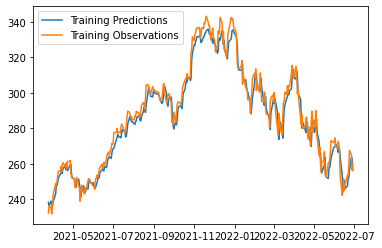

In [31]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 6ms/step


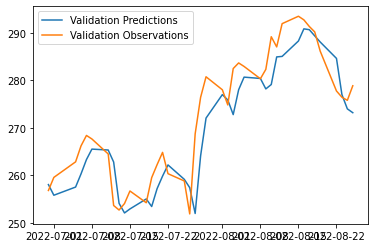

In [32]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 5ms/step


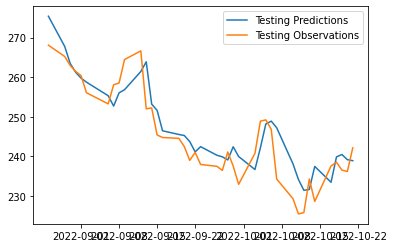

In [33]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

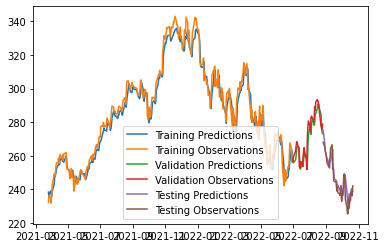

In [34]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction